In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Cargar el conjunto de datos
mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist['data'] / 255, mnist['target']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 / 3, random_state=42)
n = X_train.shape[0]
print(n)

# Parámetros de la red neuronal
L = 0.01  # Tasa de aprendizaje
num_iterations = 5_000
batch_size = 1024

# Preguntar al usuario si desea cargar los parámetros antiguos o entrenar desde cero
user_choice = input("Cargar parametros antiguos (c) o entrenar desde cero (e)? ")

#! Inicializar los parametros de la red neuronal ===============================================

#model_params_file = "model_params.npz" #este tiene precision del 90.25027856%
#model_params_file = "model_params_1.npz" #este tiene precision del 36% por ahi
#model_params_file = "model_params_2.npz" #este tiene precision del 90.99597154%  se creo desde model_params
#model_params_file = "model_params_3.npz" #este tiene precision del 91.38596040%  se creo desde model_params_2
#model_params_file = "model_params_4.npz" #este tiene precision del 93.56304106%  se creo desde model_params_3
model_params_file = "model_params_5.npz" #este tiene precision del 94.95157281%  se creo desde model_params_4

#! Inicializar los parametros de la red neuronal ===============================================

# Inicializar pesos y bias
if user_choice.lower() == 'c' and os.path.exists(model_params_file):
    # Cargar los pesos y los bias desde el archivo .npz
    try:
        params = np.load(model_params_file)
        w_1 = params['w_1']
        b_1 = params['b_1']
        w_2 = params['w_2']
        b_2 = params['b_2']
        w_3 = params['w_3']
        b_3 = params['b_3']
        print(f"Parametros cargados desde '{model_params_file}'.")
    except Exception as e:
        print(f"Error al cargar parametros: {e}")
        # Inicializar aleatoriamente si hay un error
        np.random.seed(13)
        w_1 = np.random.randn(256, 784) * 0.01
        w_2 = np.random.randn(128, 256) * 0.01
        w_3 = np.random.randn(10, 128) * 0.01
        b_1 = np.random.rand(256, 1)
        b_2 = np.random.rand(128, 1)
        b_3 = np.random.rand(10, 1)
        print("Parametros inicializados aleatoriamente.")
else:
    # Inicializar aleatoriamente los pesos y bias
    np.random.seed(13)
    w_1 = np.random.randn(256, 784) * 0.01
    w_2 = np.random.randn(128, 256) * 0.01
    w_3 = np.random.randn(10, 128) * 0.01
    b_1 = np.random.rand(256, 1)
    b_2 = np.random.rand(128, 1)
    b_3 = np.random.rand(10, 1)
    print("Parametros inicializados aleatoriamente.")

# Funciones de activación
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)

def forward_prop(X):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Derivadas de las funciones de activación
d_relu = lambda x: x > 0

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y.astype(int), np.arange(Y.size)] = 1
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    # Convertir Y a codificación one-hot
    one_hot_Y = one_hot(Y, A3.shape[0])
    
    dCE_dZ3 = A3 - one_hot_Y
    dZ3_dW3 = A2  
    dZ3_dB3 = 1
    dZ3_dA2 = w_3
    dA2_dZ2 = d_relu(Z2)
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dZ2_dA1 = w_2
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    # Calcular gradientes para W3 y b3
    dCE_dW3 = dCE_dZ3 @ dZ3_dW3.T / X.shape[1]
    dCE_dB3 = np.sum(dCE_dZ3, axis=1, keepdims=True) / X.shape[1]

    dCE_dA2 = dZ3_dA2.T @ dCE_dZ3
    dCE_dZ2 = dCE_dA2 * dA2_dZ2

    # Calcular gradientes para W2 y b2
    dCE_dW2 = dCE_dZ2 @ dZ2_dW2.T / X.shape[1]
    dCE_dB2 = np.sum(dCE_dZ2, axis=1, keepdims=True) / X.shape[1]

    dCE_dA1 = dZ2_dA1.T @ dCE_dZ2
    dCE_dZ1 = dCE_dA1 * dA1_dZ1

    # Calcular gradientes para W1 y b1
    dCE_dW1 = dCE_dZ1 @ dZ1_dW1.T / X.shape[1]
    dCE_dB1 = np.sum(dCE_dA1, axis=1, keepdims=True) / X.shape[1]

    return dCE_dW1, dCE_dB1, dCE_dW2, dCE_dB2, dCE_dW3, dCE_dB3

def calculate_accuracy(Y_true, Y_pred):
    return np.mean(Y_true == Y_pred)

# Entrenamiento por descenso de gradiente
accuracy_train_l = []
accuracy_test_l = []
for i in tqdm(range(num_iterations), desc="Training", unit="iteration"):
    np.random.seed(13)
    idx = np.random.choice(n, batch_size, replace=False)
    X_sample = X_train.iloc[idx].to_numpy().transpose()  # Transponer a (784, 4096)
    Y_sample = Y_train.iloc[idx].to_numpy()

    # Propagación hacia adelante
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    # Propagación hacia atrás
    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    # Actualizar pesos y bias
    w_1 -= L * dW1
    b_1 -= L * dB1
    w_2 -= L * dW2
    b_2 -= L * dB2
    w_3 -= L * dW3
    b_3 -= L * dB3

    # if i % 100 == 0:
        # Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward_prop(X_test.transpose())
        # predictions = np.argmax(A3_test, axis=0)
        # accuracy = accuracy_score(Y_test.astype(int), predictions)
        # accuracies.append(accuracy)  # Guardar la precisión
        # print(f"Iteración {i}, Precisión: {accuracy * 100:.8f}%")

    Z1_test, A1_test, Z2_test, A2_test, Z3_test, A3_test = forward_prop(X_test.transpose())
    test_predictions = np.argmax(A3_test, axis=0)
    
    # Calcular precisión del conjunto de prueba
    accuracy_test = np.mean(test_predictions == Y_test.astype(int))
    accuracy_test_l.append(accuracy_test)  # Asegúrate de acumular en la lista correcta

    # Calcular precisión del conjunto de entrenamiento
    train_predictions = np.argmax(A3, axis=0)
    accuracy_train = np.mean(train_predictions == Y_sample.astype(int))
    accuracy_train_l.append(accuracy_train)  # Asegúrate de acumular en la lista correcta

# Imprimir la precisión final
print(f"Precision de prueba final: {accuracy_test_l[-1] * 100:.8f}  Precision de entrenamiento final: {accuracy_train_l[-1] * 100:.8f}")

# # Guardar parametros al final del entrenamiento
# i = 0
# new_model_params_file = model_params_file
# while os.path.exists(new_model_params_file):
    # i += 1
    # new_model_params_file = f"model_params_{i}.npz"

# np.savez(new_model_params_file, w_1=w_1, b_1=b_1, w_2=w_2, b_2=b_2, w_3=w_3, b_3=b_3)
# print(f"Parametros guardados en '{new_model_params_file}'.")


46666
Parametros inicializados aleatoriamente.


Training: 100%|██████████| 5000/5000 [25:40<00:00,  3.25iteration/s]

Precision de prueba final: 82.67335219  Precision de entrenamiento final: 93.65234375


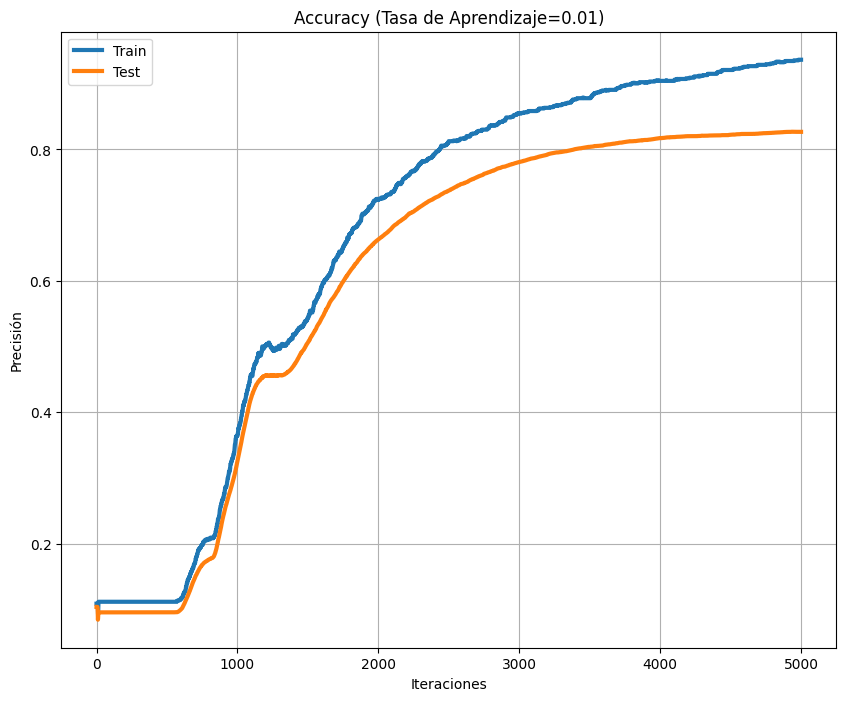

In [32]:
def accuracy_graphic(L, train_l, test_l):
    iters = len(train_l)
    fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
    fmt_test = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(iters), train_l, label='Train', **fmt_train)
    ax.plot(range(iters), test_l, label='Test', **fmt_test)
    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy (Tasa de Aprendizaje={L})')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Precisión')
    plt.savefig(f"accuracy_{L}.png")  # Guardar la figura
    plt.show()

accuracy_graphic(L, accuracy_train_l, accuracy_test_l)

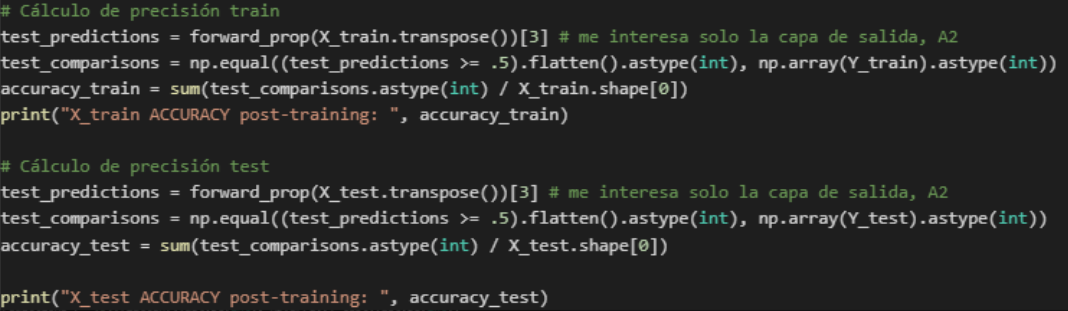

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


all_data = pd.read_csv("DATA/train.csv")

L = 0.001  # La tasa de aprendizaje

# Extraer columnas de entrada, escalarlas dividiendo por 255
X, Y = all_data.iloc[:, 1:].values / 255.0, all_data.iloc[:, 0].values

# Dividir los conjuntos de datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)
n = X_train.shape[0]
#print(n)

# Construir red neuronal con pesos y sesgos
# inicializados aleatoriamente

np.random.seed(42)

w_1 = np.random.rand(128, 784) * 0.01 #* 2 - 1
w_2 = np.random.rand(64, 128) * 0.01
w_3 = np.random.rand(10, 64) * 0.01

b_1 = np.random.rand(128, 1)
b_2 = np.random.rand(64, 1)
b_3 = np.random.rand(10, 1)

# Funciones de activación
relu = lambda x: np.maximum(x, 0)
# logistic = lambda x: 1 / (1 + np.exp(-x))

# Función softmax
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)  
# Lo que hace la softmax basicamente es convertir un vector de numeros en una distribucion de probabilidad, donde la suma de todos los elementos da 1
# tambien amplifica la diferencia entre los valores grandes y pequeños

# Ejecutar entradas a través de la red neuronal para obtener salidas predichas
def forward_prop(X):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Derivadas de las funciones de activación
d_relu = lambda x: x > 0
# def d_softmax(S):
#     # Inicializar el Jacobiano con ceros
#     jacobian = np.diag(S)
    
#     for i in range(len(S)):
#         for j in range(len(S)):
#             if i == j:
#                 jacobian[i, j] = S[i] * (1 - S[i])   # Derivada cuando i == j
#             else:
#                 jacobian[i, j] = -S[i] * S[j]       # Derivada cuando i != j
                
#     return jacobian

def one_hot(Y): # esto se hace porque ahora la salida no es binaria entonces tenes que armar una matriz de 0 y 1
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def cross_entropy(Y, Y_pred):
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    return -np.sum(Y * np.log(Y_pred)) / Y.shape[1]

def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    one_hot_Y = one_hot(Y)

    # BP1
    # dC_dB3 = dC_A3 * dA3_dZ3 @ dZ3_dB3
    # dC_A3 = A3
    # dA3_dZ3 = d_softmax(Z3)
    dC_dZ3 = A3 - one_hot_Y  # Simplificación de la derivada de softmax + cross-entropy
    # dC_dW3 = dC_dA3 * dA3_dZ3 @ dZ3_dW3
    # dC_dW3 = dC_dZ3 @ dZ3_dW3
    # dZ3_dW3 = A2.T
    dC_dW3 = dC_dZ3 @ A2.T 
    dC_dB3 = np.sum(dC_dZ3, axis=1, keepdims=True)  

    # BP2
    # dC_dW2 = dC_dA3 * dA3_dZ3 @ dZ3_dA2
    dZ3_dA2 = w_3.T 
    dC_dA2 = dZ3_dA2 @ dC_dZ3  
    dA2_dZ2 = d_relu(Z2)  
    dC_dZ2 = dC_dA2 * dA2_dZ2 
    dC_dW2 = dC_dZ2 @ A1.T
    dC_dB2 = np.sum(dC_dZ2, axis=1, keepdims=True)  

    # BP3
    # dC_dW1 = dC_dA3 * dA3_dZ3 @ dZ2_dA1 @ dA1_dZ1 @ dZ1_dW1
    dZ2_dA1 = w_2.T 
    dC_dA1 = dZ2_dA1 @ dC_dZ2  
    dA1_dZ1 = d_relu(Z1) 
    dC_dZ1 = dC_dA1 * dA1_dZ1 
    dC_dW1 = dC_dZ1 @ X.T  
    dC_dB1 = np.sum(dC_dZ1, axis=1, keepdims=True)  

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3


# Ejecutar descenso de gradiente
accuracy_train_l2 = []
accuracy_test_l2 = []
for i in range(100_000):
    # seleccionar aleatoriamente uno de los datos de entrenamiento
    idx = np.random.choice(n, 128, replace=False)
    X_sample = X_train[idx].transpose() # La transposición convierte esa fila de forma (1, 784) en una columna de forma (784, 1). Este no lo inicializas arriba por eso
    Y_sample = Y_train[idx]

    # pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    # distribuir error a través de la retropropagación
    # y devolver pendientes para pesos y sesgos
    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    # actualizar pesos y sesgos
    w_1 -= L * dW1
    b_1 -= L * dB1
    w_2 -= L * dW2
    b_2 -= L * dB2
    w_3 -= L * dW3
    b_3 -= L * dB3
    
     if i % 10_000 == 0:
        # Calcular la pérdida y la precisión en el conjunto de prueba
        _, _, _, _, _, A3_test = forward_prop(X_test.T)
        one_hot_Y_test = one_hot(Y_test)
        loss = cross_entropy(one_hot_Y_test, A3_test)

        Y_pred_train = np.argmax(A3, axis=0)
        accuracy_train = accuracy_score(Y_train, Y_pred_train)
        accuracy_train_l2.append(accuracy_train)

        Y_pred_test = np.argmax(A3_test, axis=0)
        accuracy_test = accuracy_score(Y_test, Y_pred_test)
        accuracy_test_l2.append(accuracy_test)

# Guardar parametros al final del entrenamiento
# i = 0
# new_model_params_file = model_params_file
# while os.path.exists(new_model_params_file):
#     i += 1
#     new_model_params_file = f"model_params_{i}.npz"

# np.savez(new_model_params_file, w_1=w_1, b_1=b_1, w_2=w_2, b_2=b_2, w_3=w_3, b_3=b_3)
# print(f"Parametros guardados en '{new_model_params_file}'.")

Iteración 0, Pérdida: 2.3438, Precisión del modelo: 10.692857142857143%
Iteración 10000, Pérdida: 0.1309, Precisión del modelo: 96.97142857142858%
Iteración 20000, Pérdida: 0.1523, Precisión del modelo: 97.05%
Iteración 30000, Pérdida: 0.1639, Precisión del modelo: 97.07857142857142%
Iteración 40000, Pérdida: 0.1714, Precisión del modelo: 97.1%
Iteración 50000, Pérdida: 0.1765, Precisión del modelo: 97.11428571428571%
Iteración 60000, Pérdida: 0.1809, Precisión del modelo: 97.12857142857143%
Iteración 70000, Pérdida: 0.1841, Precisión del modelo: 97.12857142857143%
Iteración 80000, Pérdida: 0.1870, Precisión del modelo: 97.14285714285714%
Iteración 90000, Pérdida: 0.1898, Precisión del modelo: 97.12857142857143%


In [13]:
def accuracy_graphic(L, train_l, test_l):
    iters = len(train_l)
    fmt_train = {'color': 'tab:blue', 'ls': 'solid', 'lw': 3}
    fmt_test = {'color': 'tab:orange', 'ls': 'solid', 'lw': 3}
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(range(iters), train_l, label='Train', **fmt_train)
    ax.plot(range(iters), test_l, label='Test', **fmt_test)
    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy (Tasa de Aprendizaje={L})')
    ax.set_xlabel('Iteraciones')
    ax.set_ylabel('Precisión')
    plt.savefig(f"accuracy_{L}.png")  # Guardar la figura
    plt.show()



NameError: name 'accuracy_train_l2' is not defined

Parametros cargados desde 'model_params_6.npz'.
The image is probably a: 0


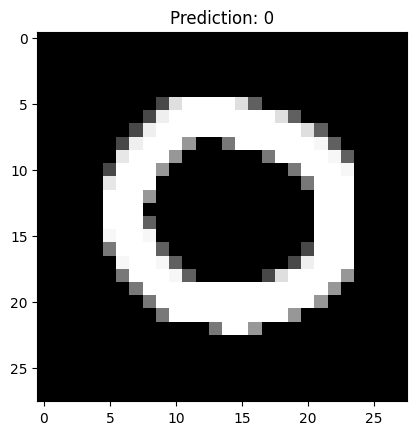

The image is probably a: 1


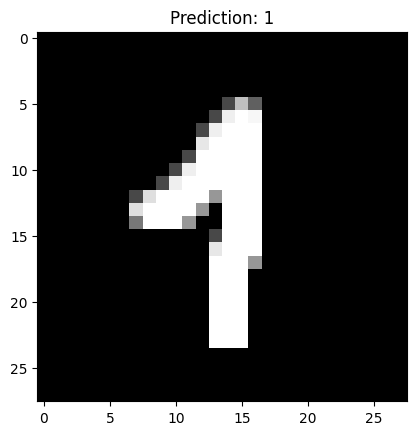

The image is probably a: 2


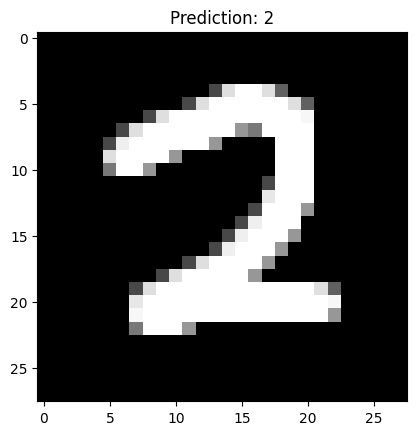

The image is probably a: 3


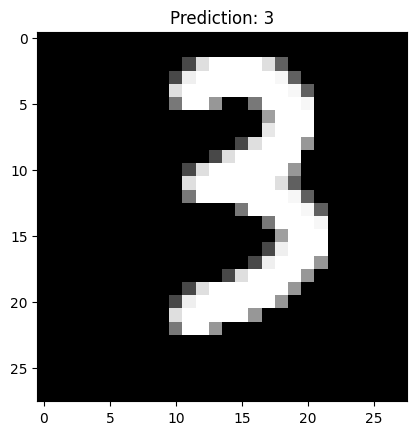

The image is probably a: 4


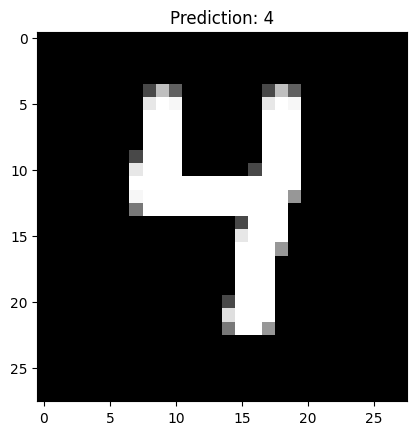

The image is probably a: 5


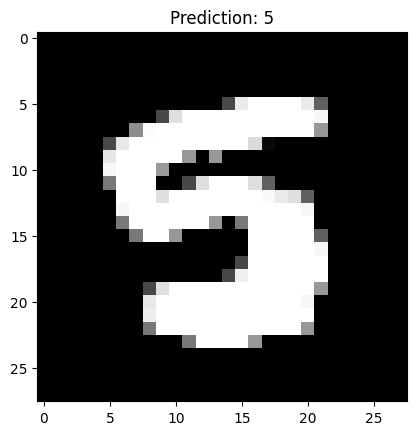

The image is probably a: 6


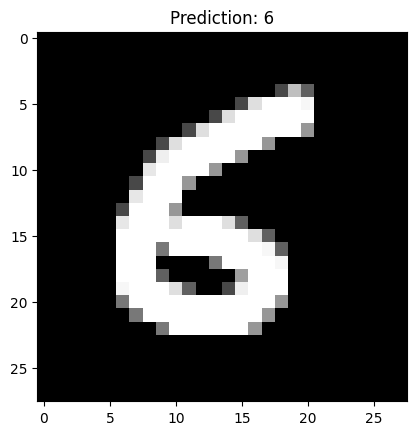

The image is probably a: 7


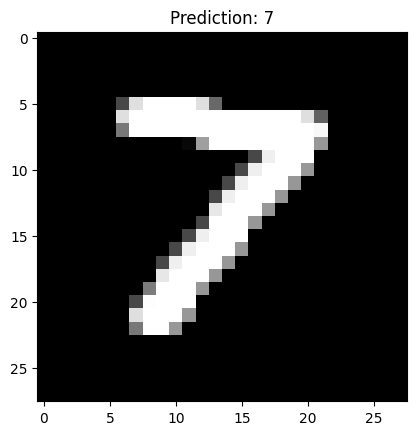

The image is probably a: 8


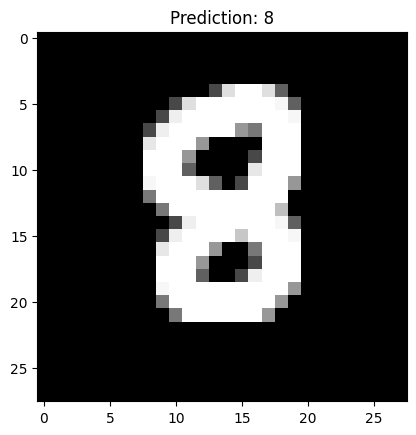

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Función para cargar los parámetros del modelo
def load_model_params(file_path):
    if os.path.exists(file_path):
        try:
            params = np.load(file_path)
            w_1 = params['w_1']
            b_1 = params['b_1']
            w_2 = params['w_2']
            b_2 = params['b_2']
            w_3 = params['w_3']
            b_3 = params['b_3']
            print(f"Parametros cargados desde '{file_path}'.")
            return w_1, b_1, w_2, b_2, w_3, b_3
        except Exception as e:
            print(f"Error al cargar parametros: {e}")
            return None
    else:
        print(f"El archivo '{file_path}' no existe.")
        return None

# Funciones de activación
relu = lambda x: np.maximum(0, x)
softmax = lambda x: np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)), axis=0)

# Propagación hacia adelante
def forward_prop(X, w_1, b_1, w_2, b_2, w_3, b_3):
    Z1 = w_1 @ X + b_1
    A1 = relu(Z1)
    Z2 = w_2 @ A1 + b_2
    A2 = relu(Z2)
    Z3 = w_3 @ A2 + b_3
    A3 = softmax(Z3)
    return A1, A2, A3

# Función de preprocesamiento de la imagen
def preprocess_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Cargar como escala de grises
    img_resized = cv2.resize(img, (28, 28))      # Redimensionar a 28x28 píxeles
    img_resized = img_resized / 255.0            # Normalizar a rango 0-1
    img_resized = img_resized.flatten()          # Aplanar la imagen a 784 elementos
    return img_resized.reshape(784, 1)           # Asegurarse de que la forma sea (784, 1)

# Inicializar los parámetros de la red neuronal
model_params_file = "model_params_6.npz"
w_1, b_1, w_2, b_2, w_3, b_3 = load_model_params(model_params_file)

# Predicción usando la red neuronal
for i in range(9):
    image_path = f'digits/digitB{i}.png'
    processed_image = preprocess_image(image_path)

    # Propagación hacia adelante para obtener la predicción
    _, _, A3 = forward_prop(processed_image, w_1, b_1, w_2, b_2, w_3, b_3)
    prediction = np.argmax(A3, axis=0)  # Obtener la clase con la probabilidad más alta

    print(f'The image is probably a: {prediction[0]}')

    # Visualizar la imagen procesada
    plt.imshow(processed_image.reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {prediction[0]}')
    plt.show()
